In [16]:
## Installing important library

!pip install ortools
!pip install geopandas

# Optimization Test Problem.

There are 500 delivery jobs assigned to a number of delivery cars (maximum 50 cars) to complete in a day. Assume that every car has the following parameters:

    •	A fixed setup cost $30 per day
    •	Travel cost $0.2 per km
    •	Average traveling speed is 40km/hour
    •	Maximum 10 working hours
    •	Un-limited capacity (car can carry any number of jobs at the same time)

1.	Find a solution to minimize the total delivery cost
2.	Find a way to visualize your solution 


**Hmmmm what can I see here...**
    
    1. Travel cost not just depend on distance, but number of vehicle use also important (30 dolar per vehicle!). So beside by finding optimal routes, we also need to minimize the vehicle usage for delivery.
    
    2. Maximum distance for each vehicle can go per day is around 400km (40km/h * 10 working hours)..but in this case, we take more reasonable distance like...320km (40km/h * 8 hours) by considering the traffic, weather, delivery time etc...so we use 320km maximum distance for each vehicle per day.
    
    3. No Depot! yup there is no location for all the vehicles to start and stop..so we consider the origin is the location where the vehicle start.

## Step 1: Read and preparing data..

In this step, I want to check how many origins and destinations involved..and mapping it with singapore map for better understanding the situation.

In [0]:
#Import all necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
%matplotlib inline

In [18]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
street_map = gpd.read_file("/content/gdrive/My Drive/vrp/singapore_highway.shp")
df = pd.read_csv("/content/gdrive/My Drive/vrp/optimization_test_data.csv")

In [20]:
##Displaying the data frame
df.head()

,point,origin_latitude,origin_longitude,destination_latitude,destination_longitude
0,0,1.301761,103.769369,1.305225,103.888417
1,1,1.368778,103.840274,1.298004,103.856936
2,2,1.386551,103.906742,1.324099,103.913303
3,3,1.389590,103.755254,1.292214,103.796440
4,4,1.389590,103.755254,1.318046,103.757619


In [0]:
##  separating the origin and destination coordinates

origin = [Point(xy) for xy in zip(df['origin_longitude'], df['origin_latitude'])]
dest = [Point(xy) for xy in zip(df['destination_longitude'], df['destination_latitude'])]

origin_df = gpd.GeoDataFrame(df, geometry = origin)
origin_df.drop(['point', 'destination_latitude', 'destination_longitude'], axis=1, inplace=True)
dest_df = gpd.GeoDataFrame(df, geometry = dest)
dest_df.drop(['point','origin_latitude', 'origin_longitude'], axis=1, inplace=True)

In [22]:
## origin coordinates
origin_df.head()

,origin_latitude,origin_longitude,geometry
0,1.301761,103.769369,POINT (103.7693694 1.301761305)
1,1.368778,103.840274,POINT (103.8402739 1.368778389)
2,1.386551,103.906742,POINT (103.9067415 1.386551487)
3,1.389590,103.755254,POINT (103.7552543 1.389589707)
4,1.389590,103.755254,POINT (103.7552543 1.389589707)


In [23]:
## Destination coordinates
dest_df.head()

,destination_latitude,destination_longitude,geometry
0,1.305225,103.888417,POINT (103.8884166 1.305225272)
1,1.298004,103.856936,POINT (103.8569357 1.298003624)
2,1.324099,103.913303,POINT (103.9133026 1.324098533)
3,1.292214,103.796440,POINT (103.79644 1.292213688)
4,1.318046,103.757619,POINT (103.7576194 1.31804628)


### Now we plot the origins and destinations coordinates..

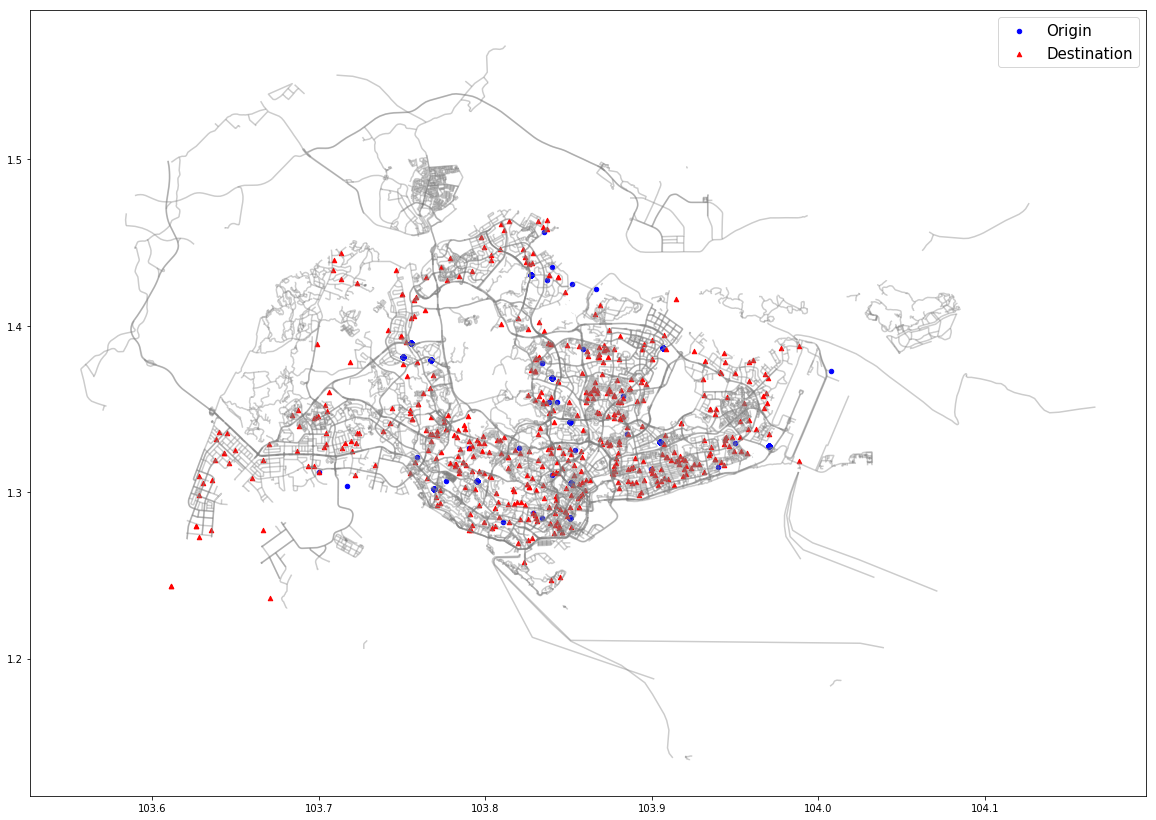

In [24]:
fig, ax = plt.subplots(figsize = (20, 20))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
origin_df.plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Origin')
dest_df.plot(ax = ax, markersize = 20, color = 'red', marker = '^', label = 'Destination')
plt.legend(prop={'size': 15})

### As you can see from the map..

    1. Some 500 origin cordinates are actually same..same goes to destinations coordinate
    2. Its a good news (maybe?) since we might not going to use all the 50 vehicles in our dispossal.

### Now we prepare the data by compiling the destinations coordinates based on their origin. 

In [25]:
## Data preparation..

from geopy.distance import great_circle

warehouse = origin_df.origin_latitude.unique() ## warehouse means origin
distance_matrix = []
location_matrix = []
location_matrix2 = []

## Combining data
for i in range (len(warehouse)):
    j = i+1
    ori = df.loc[df['origin_latitude']==warehouse[i]]
    ori = np.array(ori[['origin_latitude', 'origin_longitude']])
    des = df.loc[df['origin_latitude']==warehouse[i]]
    des = np.array(des[['destination_latitude', 'destination_longitude']])
    dist = np.vstack((ori[0], des))
    t = dist.shape[0]
    dist_mat = np.zeros((t,t), dtype=np.uint32)
    
    if t < 3:
        location_matrix2.append(dist)
    else:
        for k in range(t):
            for h in range(t):
                dist_mat[k,h]=great_circle(dist[k], dist[h]).m
        print("point {}, with number of destination {}, with max distance from origin {} meter".format(j, des.shape[0], np.amax(dist_mat)))
    
    
        location_matrix.append(dist)
        distance_matrix.append(dist_mat)

t2 = len(location_matrix2)
print("\n\nNow we see that only {} origins has multiple destinations, while remaining {} have one destination.\n".format(len(location_matrix), t2))         
print("\n Combining the one destination into a list and creating the index matrix....")
i2 = t2*2
index_matrix = np.arange(1, i2+1).reshape(t2,2)

print("\n jobs done...")

point 1, with number of destination 30, with max distance from origin 39069 meter
point 2, with number of destination 26, with max distance from origin 23203 meter
point 3, with number of destination 31, with max distance from origin 27131 meter
point 4, with number of destination 37, with max distance from origin 34956 meter
point 5, with number of destination 48, with max distance from origin 34832 meter
point 6, with number of destination 36, with max distance from origin 34840 meter
point 7, with number of destination 39, with max distance from origin 40124 meter
point 8, with number of destination 28, with max distance from origin 25313 meter
point 10, with number of destination 28, with max distance from origin 26261 meter
point 12, with number of destination 49, with max distance from origin 39536 meter
point 13, with number of destination 39, with max distance from origin 40934 meter
point 15, with number of destination 33, with max distance from origin 41487 meter
point 16, wi

### We can see hear that few origins has multiple destinations and few others with only one destination. What we can do is:

    1. For multiple destinations, we use Vehicle Routing Problem (VRP) method to find the optimize routes for each origins.
    2. While for single destination, we combined it together as a one list, then we try to solve it by using Simple Pickup Delivery Problem (PDP).
    
#### Thanks to google for their awesome tool [ORTOOLS](https://developers.google.com/optimization/install/), it save me months from writing codes from scratch.

## Step 2: Solving the origin with multiple destinations with [Vehicle Routing Problem (VRP)](https://en.wikipedia.org/wiki/Vehicle_routing_problem)

Now we go to the step two..you can get this code from [HERE](https://developers.google.com/optimization/routing/vrp)

In [0]:
"""Vehicles Routing Problem (VRP)."""

##  Create data and display solution functions

def create_data_model(dist, vehicle):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = dist
    data['num_vehicles'] = vehicle
    data['depot'] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    di = []
    for vehicle_id in range(data['num_vehicles']):
        v = vehicle_id + 1
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:'.format(v)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        total_cost = ((route_distance/1000) * 0.2) + 30
        plan_output += 'Total cost: %5.2f Dolar'%(total_cost)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        di.append(total_cost)
        sdi = sum(di)
        if v > 1:
            print("Sum of total cost: {} Dolar: ".format(np.int16(yhhyh)))
    print('Maximum of the route distances: {}\n\n'.format(max_route_distance))
    return sdi ## return cost

In [0]:
## Create the main function

def vrp(distance_matrix, origin, vehicles, maxdist):
    tc = [] ## Total cost
    for y in range(origin):
        vehicle = vehicles[y]
        n = y+1
        dist = distance_matrix[y]
        
        print("calculating distance for origin: {}".format(n))
        print("Number of vehicle involved: {}\n".format(vehicle))
        """Solve the CVRP problem."""
        # Instantiate the data problem.
        data = create_data_model(dist, vehicle)

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)


        # Create and register a transit callback.
        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Add Distance constraint.
        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  # no slack
            maxdist,  # vehicle maximum travel distance
            True,  # start cumul to zero
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        distance_dimension.SetGlobalSpanCostCoefficient(100)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        # Print solution on console.
        if solution:
            t = print_solution(data, manager, routing, solution)
            tc.append(t)
    return tc

### Now we run the VRP code..as you can see that few parameters needed

    * Vehicles - array - Number of vehicles you want to use for each origin. Each index represent the origins.
    * no_origin - interger - number of origins.
    * distance_matrix - list- list of coordinates based on the origin.
    * max distance - interger - We set it as 320000 (320km).

In [28]:
no_origin = len(distance_matrix)
vehicles = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] ##number of vehicle for each origin.
route = vrp(distance_matrix, no_origin, vehicles, 320000)

calculating distance for origin: 1
Number of vehicle involved: 1

Route for vehicle 1: 0 ->  8 ->  12 ->  18 ->  27 ->  13 ->  6 ->  16 ->  29 ->  5 ->  7 ->  14 ->  3 ->  30 ->  19 ->  26 ->  17 ->  28 ->  2 ->  21 ->  24 ->  15 ->  22 ->  9 ->  1 ->  20 ->  11 ->  4 ->  25 ->  23 ->  10 -> 0
Distance of the route: 112613m
Total cost: 52.52 Dolar
Maximum of the route distances: 112613


calculating distance for origin: 2
Number of vehicle involved: 1

Route for vehicle 1: 0 ->  16 ->  18 ->  5 ->  23 ->  7 ->  4 ->  14 ->  24 ->  15 ->  21 ->  10 ->  12 ->  22 ->  1 ->  13 ->  2 ->  8 ->  20 ->  19 ->  25 ->  17 ->  3 ->  11 ->  26 ->  6 ->  9 -> 0
Distance of the route: 85948m
Total cost: 47.19 Dolar
Maximum of the route distances: 85948


calculating distance for origin: 3
Number of vehicle involved: 1

Route for vehicle 1: 0 ->  26 ->  17 ->  14 ->  11 ->  12 ->  4 ->  1 ->  25 ->  20 ->  9 ->  31 ->  3 ->  21 ->  2 ->  23 ->  8 ->  6 ->  18 ->  27 ->  28 ->  5 ->  24 ->  16 ->  13

### After you run the VRP function..you get the optimal distances and cost involved for each origins..if its not satisfying, play around with the parameters such as adding more vehicle.


#### Netx, we prepare the data list for next method to solve

As you can see, the origin 14 have the lowest cost and route distance (Just 23km and 34.63 Dolar). So instead we are using a new vehicle, for next solution..we can use the same vehicle  to solve the next problem, from there we can save the minimum of 30 Dolar by not using new vehicle.

In [29]:
## Retreiving the minimum cost from previous solution.

length = len(index_matrix)*2
location_matrix2 = np.array(location_matrix2).reshape(length,2) ## reshape the list from (25,25) to (50,2)

min_index = np.argmin(route) ## index of minimum cost from total routes
lo_cost = min(route)
print("lowest cost is {}, at origin {}.".format(lo_cost, min_index+1))
print("\n So we are going to use the vehicle on this origin to continue with one origin one destination delivery")
min_cost = np.array(location_matrix[min_index][0])
min_cost.tolist()
#pppp = np.array(location_matrix2)
location_matrix3 = np.insert(location_matrix2, 0, min_cost, 0) ## setting up new location matrix by adding origin of mminimum route

t3 = location_matrix3.shape[0]
distance_matrix2 = np.zeros((t3,t3), dtype=np.uint32)

## calculating distance matrix
for r in range(t3):
    for r2 in range(t3):
            distance_matrix2[r, r2] = great_circle(location_matrix3[r], location_matrix3[r2]).m

lowest cost is 34.6344, at origin 14.

 So we are going to use the vehicle on this origin to continue with one origin one destination delivery


## Step 3: Simple Pickup Delivery Problem (PDP)

Again..thanks google for the saviour! You can get the code [HERE.](https://developers.google.com/optimization/routing/pickup_delivery)

In [0]:
"""Simple Pickup Delivery Problem (PDP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix2
    data['pickups_deliveries'] = index_matrix
    data['num_vehicles'] = 1
    data['depot'] = 0 ## origin of last minimum solutions
    return data


def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))
    return total_distance


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Define cost of each arc.
    def distance_callback(from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        320000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Define Transportation Requests.
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(
                delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(data, manager, routing, assignment)
    else:
        print("No solution..")


if __name__ == '__main__':
    main()

In [0]:
## Calculate total actual total costs
dc = len(distance_matrix)
## Total cost delivery cost from Second step:
total_cost = sum(route)
total_distance = (total_cost - (30*dc))/0.2 ## Counting total distance covered from all vehicles from step 2
total_cost2 = (165190/1000)*0.2
actual_cost = total_cost + total_cost2
actual_distance = (165190/1000) + total_distance

print("For VRP: Total distance covered for {} vehicles is {} kilometer. With delivery cost of {} Dolar".format(dc, np.int32(total_distance), np.int32(total_cost)))
print("Delivery cost covered by 0 new car in step 3 is: {} Dolar".format(np.int32(total_cost2)))
print("Sum total delivery cost for both steps are: {} Dolar, with total distance covered: {} kilometer".format(np.int(actual_cost), np.int(actual_distance)))

### Now we get the estimate delivery cost and distance for all vehicles in both VRP and PDP method.

#### Few improvement can be made:

    * Set the depot location
    * Get the actual distance from Google API (which is not free)
    * Integrate with other data such as weather, traffic, and delivery  time to get better and accurate calculation.
    * Make graph for better presentation on every route.